0.5663409708295999
-18205.043202481123
0.03858449750531706


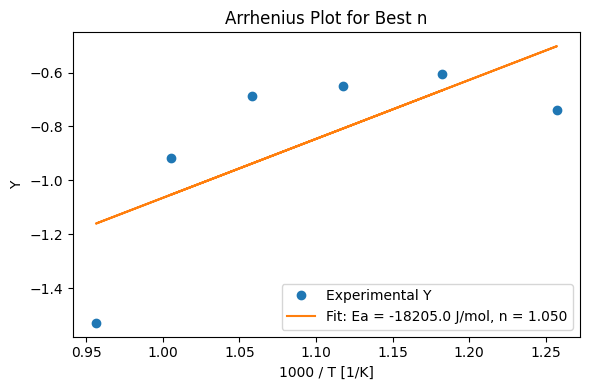

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

'''I assume that the entire SMR reaction happens instantly and then we do WGS after. Not the most accurate prob. 
We could integrate along the reaction (setting up a dPCH4 and using that to solve through dPCO2) 

THIS IS INCORRECT I NEED TO ADJUST THE PARTIAL PRESSURES DURING INITIALLIZATION LIKE IN THE INTEGRATION

If we ever want to be more accurate we have to adjust the accuracy of our outlet partial pressures
'''

# === INPUT DATA ===
dP_CO = 0.00001

P_CH4_in = 0.2029 # bar
P_CH4_out_Data = np.array([0.1018, 0.0419, 0.0144, 0.1350, 0.0718, 0.0192])  # bar
dCH4 = P_CH4_in - P_CH4_out_Data

T_data = np.array([845.79, 945.17, 1045.52, 795.41, 894.75, 994.56])  # Temperature in K
P_CO2_in = 0 # bar
P_H2O_in_data = 0.6087 - dCH4 # bar
P_H2_in_data = 0.125565 + 3*dCH4 # bar
P_CO_in_data = dCH4 # bar
P_CO2_out_Data = np.array([0.04368, 0.04136, 0.02022, 0.03449, 0.04366, 0.033435])  # bar
# P_CO_out_Data = np.array([0.022676, 0.063839, 0.1034077, 0.010517, 0.043659, 0.09057])  # bar
V_R = 2343.7 * 10**-9  # Reactor volume in m^3
total_flow = (16.16 + 10 + 48.48 + 5)/60000000 #m^3/s
S_V = total_flow/V_R  # 1/sec
print(S_V)
R = 8.314  # J/mol/K

P_Ar = 1 - (P_CH4_in + P_H2O_in_data[0] + P_H2_in_data[0] + P_CO_in_data[0])

Ptotold = 1 # bar

# === EQUILIBRIUM CONSTANT FUNCTION ===
def K_eq(T):
    return np.exp(4400/T - 4.036)

# === INTEGRAL FUNCTION ===
def integral_I(n, T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in):
    sum = 0
    #adjust these to get the data when you are done
    P_CO2 = P_CO2_in
    P_H2O = P_H2O_in
    P_H2 = P_H2_in
    P_CO = P_CO_in

    while P_CO2 < P_CO2_out:
        sum = sum + dP_CO/((P_CO**n) * (P_H2O**n) - 1/(K_eq(T)) * (P_CO2**n) * (P_H2**n))
        P_CO2 = P_CO2 + dP_CO
        P_H2O = P_H2O - dP_CO
        P_H2 = P_H2 + dP_CO
        P_CO = P_CO - dP_CO

        #pressure normalization
        Ptotnew = P_CO2 + P_H2O + P_H2 + P_CO + P_Ar
        P_CO2 = P_CO2*Ptotold/Ptotnew
        P_H2O = P_H2O*Ptotold/Ptotnew
        P_H2 = P_H2*Ptotold/Ptotnew
        P_CO = P_CO*Ptotold/Ptotnew
    return sum

# === SCAN n VALUES AND FIT ===
n_range = np.linspace(0.5, 1.05, 50)
results = []

for n in n_range:
    I_n = np.array([integral_I(n, T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in)
                    for T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in in 
                    zip(T_data, P_CO2_out_Data, P_H2O_in_data, P_CO_in_data, P_H2_in_data)])
    expY = (S_V * I_n)
    Y = np.log(expY)
    inv_T = 1 / T_data
    slope, intercept, r_value, _, _ = linregress(inv_T, Y)
    Ea = -slope * R
    results.append({
        'n': n,
        'Ea_Jmol': Ea,
        'slope': slope,
        'intercept': intercept,
        'r_squared': r_value**2
    })

# === SELECT BEST n ===
best_result = max(results, key=lambda d: d['r_squared'])
best_n = best_result['n']
best_slope = best_result['slope']
best_intercept = best_result['intercept']
best_Ea = best_result['Ea_Jmol']
print(best_Ea)
print(np.exp(best_intercept))

# === PLOT BEST FIT ===
I_best = np.array([integral_I(best_n, T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in)
                    for T, P_CO2_out, P_H2O_in, P_CO_in, P_H2_in in 
                    zip(T_data, P_CO2_out_Data, P_H2O_in_data, P_CO_in_data, P_H2_in_data)])
expY_best = (S_V * I_best)
Y_best = np.log(expY_best)
inv_T = 1 / T_data
Y_fit = best_slope * inv_T + best_intercept

plt.figure(figsize=(6, 4))
plt.plot(inv_T*1000, Y_best, 'o', label='Experimental Y')
plt.plot(inv_T*1000, Y_fit, '-', label=f'Fit: Ea = {best_Ea:.1f} J/mol, n = {best_n:.3f}')
plt.xlabel('1000 / T [1/K]')
plt.ylabel('Y')
plt.title('Arrhenius Plot for Best n')
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()